In [2]:
#Populating the interactive namespace from numpy and matplotlib
%pylab inline
import pandas as pd
import numpy as np
import scipy

Populating the interactive namespace from numpy and matplotlib


---
# Classifying Noisy Digits - Comp 598 Project 3 Report

#### Team: Duck Duck Duck

#### Stuart Spence, Josh Romoff, Charlie Bloomfield

---
## Introduction

Image classification is an area of computer science that borrows techniques form machine learning, computer vision and data science to categorize images. It involves several tasks: image processing, feature extraction, feature learning etc.

In this report, we present our methods for classifying a modified [MNIST](http://yann.lecun.com/exdb/mnist/) dataset. Each of the images in the original MNIST dataset has been modified by several tranformations: embossing, rotation, scaling, and a texture overlay. We explore several data-preprocessing techniques and several training models in search of the best way to classify these images, and present a fine-tuned Convolutional Neural Network as the best model for classifying images.

---
## Data Preprocessing Methods

#### Augmenting the dataset

A common mantra in machine learning is that more data beats a better algorithm. In this project, we were presented with 50,000 processed images to learn with. While this is a sizeable dataset, we knew that adding to the dataset may improve the performance of our learners.

Our first approach to augmenting the dataset involved rotating each image in the provided dataset by 0, 90, 180, and 270 degrees. We suspected that adding these rotations could aid our Neural Network in becoming more robust with regards to rotational variance between images. Image rotations can by performed easily using [scipy's rotate](http://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.ndimage.interpolation.rotate.html) function, which rotates an array about an axis. An example usage is shown below.

In [7]:
# Create a random image with the same dimensions and format as those in the dataset.
image48 = np.rand.randn((48, 48))

# Rotate image in the (x, y) plane counterclockwise by 90 degrees
rotated_image = scipy.ndimage.interpolation.rotate(image, 90)

ImportError: cannot import name _ni_support

---
Our second approach for augmenting the dataset involved downloading the original MNIST data and processing it in a way similar to the images provided. We knew the transformations that the provided images had been processed with, so transforming MNIST images in a similar fashion was rather simple. MNIST images have a 28 x 28 pixel resolution, so we first rescaled the images to match the provided dataset's 48 x 48 resolution using [scipy's imresize](http://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.misc.imresize.html) function and then used [scipy's imfilter](http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.misc.imfilter.html) function to emboss each image. We could then rotate images in the same way mentioned previously.

The full process is show below:

In [8]:
# resolution of MNIST images
num_pixels = 28 * 28

# one dimensional array is the MNIST
flat_mnist_image = np.random.randn(num_pixels)

# first step in processing the image is to reshape it into matrix form
mnist_image = np.reshape(flat_mnist_image, (28, 28))

# we then scale the image to match the 48 x 48 resolution
resized_mnist_image = scipy.misc.imresize(mnist_image, (48, 48))

# and finally we emboss the image
filtered_mnist_image = scipy.mist.imfilter(resize_mnist_image, 'emboss')

NameError: name 'scipy' is not defined

Unfortunately, we were not able to leverage the processed MNIST dataset as increased the raw dataset size to greater than 10GB. At this size, the machine on which we were running our learners could not support the entire dataset. Had we initially considered how to structure our model training such that we did not need the entire dataset to be in memory at once, we could have utilized these images and we expect that we would have had at least marginal improvements in the classification performance of our Neural Network.

#### Trimming Images

Another method we applied in data preprocessing involved trimming the edges of the images before passing them as input to the classifiers. We suspected that the edges added meaningless noise to our feature set, slowing down our learning times and causing the learners to overfit. This method proved to be effective, improving the accuracy of our Neural Network by over half a percentage point.

## Feature Design Methods

blah blah blah

-----
## Algorithms Used

---
#### Logistic Regression

Logistic Regression is a statistical method that can be used for binary classification (classification of data that can be in one of two classes). It is based on the log-odds function, and uses it to compute the likelihoood that a test instance is part of a given class.

The log odds ratio is defined as follows:
$$\ln(\frac{p}{1 - p})$$

For each feature, we can use the log odds ration to determine a probabalistic relationship between the feature and the instance's class. This is a commonly used technique for feature selection, as it provides a way to filter features that show little correlation to any of the output classes.

For the task of classification, one can solve for the set of weights that maximizes the likelihood of observing the values in the test set. With this, one can find the log-odds likelihood that a new instance is part of a given class with the following expression:

$$p_{W}(x) = \frac{1}{1 + e ^ {-W ^ {T} x}}$$

One drawback of Logistic Regression for the problem at hand is that it only classifies binary data. It can be adapted to a multi-class problem by applying binary classification for each class versus the group of all other classes, reffered to as one-versus-all classification. The likelihood of each class versus the group can then be compared and we can choose the class that is has highest probability for the given inputs. Unfortunately, one-versus-all is a costly classification technique, and does not scale well to datasets with many classes. For the digit dataset at hand, we'll need to generate ten sets of weights, one for each class of digit.

---
##### Results

We used [scikit-learn's logistic regression classifier](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). This classifier provides many hyperparameters for model tuning, and integrates with the [Pipeline](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) and [GridSearch](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html) classes provided by scikit-learn, which let us easily explore different hyperparameter and feature selection combinations to isolate which combinations provide the best classification accuracy. 

We explore two of the provided parameters: the regularization strength and the penalization norm used by the cost function. The following table shows the best best results for a grid search over a large set of C values with 10-fold cross validation.

|    |L1   |L2  |
|-----|-----|----|
|C = 1.0  |19.6%|19.6%|
|C = 2.0  |18.8%|19.8%|
|C = 10.0 |17.8%|19.8%|


As shown, Logistic Reggression techniques performed poorly in the domain of transformed image classification. Furthurmore, the variances amongst the classiciation percentages of show little correlation between changes in the model's hyperparameters. Nonetheless, it provided us with a baseline against which we could compare our other models.

---
#### Linear Support Vector Machine (SVM)

Linear SVM classification is another statistical technique that can be used for binary classification. SVMs classify data points by finding a hyperplane in the dataset's feature space that optimizes a conceptually simple constraint problem.

The approach involves finding the hyperplane that **maximizes the minimum geometric margin** of the given feature set, where the geometric margin is define as follows:

$$\gamma = y_{i} \Big[\big(\frac{W}{||W||}\big) ^ {T} x_{i}\Big]$$

$$where: y_{i} = \{-1, 1\} $$

This expression can be optimized by solving the maximization function:

$$max_{\gamma, W} (\gamma)$$

Subject to the constraints:

$$y_{i}(W ^ {T} x_{i}) \ge \gamma$$

$$||W|| = 1$$

---
Unfortunately, this expression is not optimazable because the second of the two constraints is not convex. But, the expression can be rewritten in the following form:

$$min_{\gamma, W} \Big(\frac{1}{2}||W||^{2}\Big)$$

Subject to the constraint:

$$y_{i}W^{T}x_{i} \ge 1$$


In this form, we have an expression that can be solved using standard optimization techniques, namely quadrtic optimization. But, we must consider how to fit the hyperplane without perfectly linear seperation. Many datasets are simply not linearly separable. More importantly, we often do not want to fit a hyperplane to perfectly separate our test data, but instead want to fit a hyperplane that generalizes well to data not in our dataset (ie. not overfit). To accomplish this goal, we can add a cost function to the geometric margin expression.

This results in the following optimization function:

$$min_{W} \Big[\frac{1}{2}||W||^{2} + \Big( C \sum_{m=1}^{m} \xi_{i} \Big)\Big]$$

Subject to the constraints:

$$y_{i}W^{T}x_{i} \ge 1 - \xi_{i}$$

$$\xi_{i} \ge 0$$

---
As with logistic regression, SVMs are designed to to classify binary data, and can be adapted to a multi-class settings by using one-versus-all classification. Again, this is a costly operation as we need to find a decision boundary for each of the ten classes of digits.

It is worth noting here that this discussion did not consider non-linear decision boundaries. The methods discussed above can be adapted to other types of decision boundaries, such as polynomials.


---
##### Results

We used [scikit-learns support vector classifier](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html). With this classifier came built in support for hyper-parameterizing the cost constant defined in the optimization function above. The following table shows the classification accuracy of the linear SVC hyperparameterized by different values of C, the cost constant.

|C    |Accuracy   |
|-----|-----|
|1.0| 21.2%|
|10.0|23.4%|
|100.0|20.8%|
|1000.0|20.6%|

This is a slight improvement over the performance of the Logistic Regression classifier, though only minimally. As with Logistic Regression, the variance for the set of foldsdifferent values for the hyperparameter C showed little correlation 

#### Full Implementation for Part 3

Part 3 requires a fully connected neural network with backpropagation. We also implemented mini-batch and a dynamic learning rate.

For mini-batch, instead of performing weight adjustments after every backpropagation, we sum the corrections and defer their application until X amount of trials. This saves us some processing time because weight adjustments are very computation heavy operations (discussed later).

For the dynamic learning rate in part 3, we simply did a linear interpolation. There is a starting learning rate, and a final learning rate. Given what percent done we are in processing our samples, we gradually approach the final (usually smaller) learning rate.


## Optimization

#### Python Neural Network Full Implementation
For part 3 of the assignment, we used numpy to perform matrix and vector operations. This is a far better alternative than using iterations in Python, because Python is not a compiled language. This made dramatic performance improvements in our custom implementation neural network. However we did not verify these performance increases because this is a well documented aspect of Python and numpy.

Our Python implementation badly needed (and still needs more) optimization. We concluded this after we implemented a simple PerformanceTimer class (found in utilities.py) to monitor time usage for various parts of our neural network computations. In order of most time consuming:

<pre>ADJUST WEIGHTS 166.40998 ms (401 times)
FORWARD 30.38259 ms (201 times)
START 18.95308 ms (2 times)
CORRECTIONS 0.38668 ms (401 times)
NP.ARRAY DESIRED 0.01468 ms (201 times)
OUTPUTS MINUS DESIRED 0.00732 ms (201 times)
OVERHEAD 0.06398 ms (200 times)</pre>

We learned that matrix addition and subtraction did not cost much, forward passes cost some, and the weight adjustment at each back propagation is very expensive. We decided to implement the mini-batch strategy. Unfortunately, this only defers a matrix times a constant operation, and a matrix minus a matrix operation. The costly matrix dot operation to calculate the corrections according to each output of each forward pass still must be done, even in the mini-batch system.

Results vary greatly depending on the size of the neural network. But on larger networks and without mini-batch, on a fairly powerful cloud computing instance (Digital Ocean 4 core 8GB RAM) we could only process on the order of 30 training items per second. With mini-batch we generally saw a 30% improvement, to about 40. It's possible that our specific implementation of the neural net did not allow much performance increase with mini-batch.

Full performance results for all trials can be seen <a href="https://drive.google.com/file/d/0B2lkEEFpyGuBWHU2Y0dmalhZbE0">here</a>.

## Hyperparameter Selection

#### Python Neural Network Full Implementation
For the custom implementation we wanted to raise its performance in lieu of developing more sophisticated neural network techniques from scratch (like a convolutional neural network). We considered many variations of the hyperparameters of: hidden layer count, hidden layer size, batch size, learning rate, and dynamic learning rates. In summary, by far the most significant hyperparameter was simply time spent in training, or trial count. Given the slow performance of our custom built neural network (compared to the scikit learn model used by our group) we were not able to adequately explore hyperparameters. Ideally, we'd have used orders of magnitude greater numbers of trials and neuron counts. As a result, the following results are more a proof of concept and an exploration of the lower bounds of our custom implementation.

For all hyperparameters in the following tables, these were the defaults unless specified otherwise:

<pre>Trial count of 50000. 1 hidden layer, size 600. Learning rate 0.03, final learning rate 0.003. Batch size 1000.</pre>

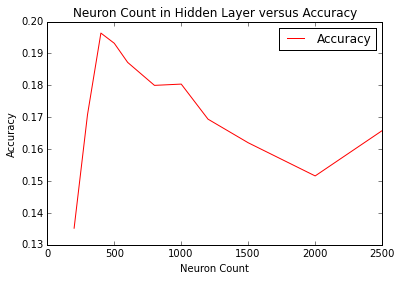

In [31]:
data = pd.read_csv('../data/performance/1hidden.csv').values
data=data[1:,:]
plt.plot(data[:,0], data[:,1], 'r', label='Accuracy')
plt.xlabel('Neuron Count')
plt.ylabel('Accuracy')
plt.title('Neuron Count in Hidden Layer versus Accuracy')
plt.legend(loc='best')

It appears that a simple 1 hidden layer network worked best with 400 nodes. However, these minor random fluctuations would likely prove meaningless had we explored larger node counts and greater trial sizes. 

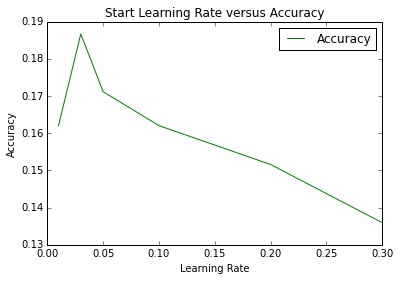

In [30]:
data = pd.read_csv('../data/performance/learning-rates2.csv').values
plt.plot(data[:,0], data[:,1], 'g', label='Accuracy')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.title('Start Learning Rate versus Accuracy')
plt.legend(loc='best')

With our low trial sizes, and low number of trials, a learning rate of 0.03 appeared best.

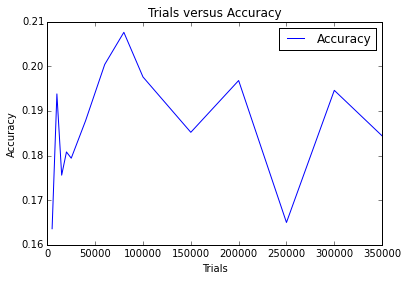

In [32]:
data = pd.read_csv('../data/performance/trials.csv').values
plt.plot(data[:,0], data[:,1], 'b', label='Accuracy')
plt.xlabel('Trials')
plt.ylabel('Accuracy')
plt.title('Trials versus Accuracy')
plt.legend(loc='best')

It appears that the neural network is still perusing local minima. Since the highest value for trial count in the above table is only 350,000, there was still more data to collect. Had our part 3 implementation been faster, we likely would have seen accuracy increase as we performed one million, or ten million, backpropagations. The graph is especially jagged below 50000 trials because there are more trials, since they completed much faster.

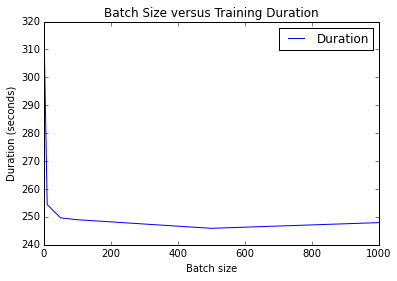

In [33]:
data = pd.read_csv('../data/performance/batch-size-600.csv').values
plt.plot(data[:,0], data[:,1], 'b', label='Duration')
plt.xlabel('Batch size')
plt.ylabel('Duration (seconds)')
plt.title('Batch Size versus Training Duration')
plt.legend(loc='best')

The benefits of mini-batch show diminishing returns very quickly.

We also explored 2 hidden layer combinations with node counts up to 3000. However because of computation time, we weren't able to find much difference. For our final training session, we settled on 1500 nodes in the first hidden layer, and 500 nodes in the second hidden layer, because it appeared to be a decent trade off between training time and accuracy.

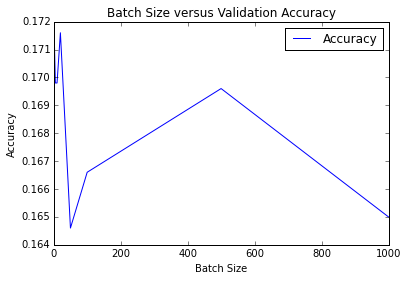

In [35]:
data = pd.read_csv('../data/performance/batch-size-1500.csv').values
plt.plot(data[:,0], data[:,1], 'b', label='Accuracy')
plt.xlabel('Batch Size')
plt.ylabel('Accuracy')
plt.title('Batch Size versus Validation Accuracy')
plt.legend(loc='best')

Observe the Y axis: accuracy hardly varies. Through this trial and various others, we concluded batch size did not significantly impact validation accuracy, especially when running larger training sessions.

## Testing and Validation

#### Python Neural Network Full Implementation

The early stages of development for part 3 included a test suite (found in tests/test_nn.py). Given a reasonable learning rate and 10,000 passes, the test suite verified that the neural network code could learn the following boolean functions (in increasing order of presumed difficulty):

A xor B. 1 hidden layer, 2 nodes, 
A xor B. 2 hidden layers, 2 nodes, 
A xor B. 1 hidden layer, 6 nodes, 
A or (B xor C). 1 hidden layer, 10 nodes, 
A or (B xor C). 1 hidden layer, 10 nodes, minibatch, 
2 booleans, 3 outputs. 1 hidden layer, 50 nodes.

After these generally succeeded, we moved on to manual testing and validation with the neural net interface (main.py). It provides command line control over the various hyperparameters like hidden layer count, hidden layer size, batch size, learning rate, and dynamic learning rates. Here is an example command used for our final training session:

<pre>python3 main.py ../../data/data_and_scripts/train_inputs.csv ../../data/data_and_scripts/train_outputs.csv --sizes=2304,1500,500,10 --validate --trials=180000 --learn-rate=0.03 --validation-ratio=0.9 --random --normalize --report --final-learn-rate=0.003 --timer=600 --verbose --batch=1000</pre>

You can also get command line help with this command:

<pre>python3 main.py -h</pre>

Once we had an idea of what basic orders of magnitude were best for the hyperparameters, we were ready to collect data on various hyperparameter configurations systematically (explored in the hyperparameter section).

#### Validation of Full Implementation

A simple validation was performed. The validation-ratio parameter specifies how much of the training set to reserve for validation. It is optionally shuffled randomly. Typically, 90% of the set was used for training and 10% for validation. Finally, after all training sessions our reports included the accuracy of the neural network on the training set as well as the validation set. Sadly, we never encountered overtraining because the custom implementation was too slow, but we were guarding against it nevertheless. The full training and validation accuracies for all trials can be found <a href="https://drive.google.com/file/d/0B2lkEEFpyGuBWHU2Y0dmalhZbE0">here</a>.

## Discussion



#### Python Neural Network Full Implementation

Although our full implementation did not achieve very high accuracies, it was significantly better than random. Given the difficulty of the data set, and the fact that it was a rather simple backpropagation implementation, the black magic of neural networks was still apparent.

A number of image transformations and enhancements, taken advantage of by our scikit learn approach, were not used in our full implementation. Many of those data preprocessing steps were ready for use too late in development to be useful, especially given how slow the hyperparameter search was. The part 3 implementation operated entirely on the initial csv dataset.

Further development of the neural net was difficult. Stuart's home laptop died months ago, so he has been using his school laptop with just 3GB of ram! He was not able to process the full dataset in any meaningful way locally. Eventually we moved testing and validation to Digital Ocean cloud computing.

One aspect we did not take advantage of is multiple hidden layers. We only tested and ran hyperparameters searches with one, sometimes two, hidden layers. When in fact our implementation can handle an arbitrary number of hidden layers. We did not choose to spend time on this given the consensus in the class that two hidden layers is more than enough. Given the sensitivty of hyperparameters, especially the learning rate, we opted not to investigate further. Convolutional neural networks are, after all, a better approach to handling many hidden layers, as demonstrated by the other sections of our report.

## Statement of Contributions

#### Stuart Spence

Stuart built the full implementation of the neural network in Python for part 3, including the mini-batch and dynamic learning rate. This includes the interface and gradient descent backpropagation. He also collected data for this section, and wrote his corresponding sections of the report.

#### Josh Romoff

stuff!

#### Charlie Bloomfield

Charlie explored optimizing hyperparameters for Logistic Regression and SVC, and wrote methods for augmenting the provided dataset with various image transformations. He collected data for these sections, and wrote the corresponding sections in this report. 


#### We hereby state that all the work presented in this report is that of the authors.

---
## References

1. http://www.sersc.org/journals/IJMUE/vol8_no4_2013/39.pdf
2. http://www.inb.uni-luebeck.de/publications/pdfs/LaBaMa08c.pdf
3. https://github.com/mnielsen/neural-networks-and-deep-learning
4. http://vip.uwaterloo.ca/files/publications/Gaussian%20MRF%20rotation-invariant%20features%20for%20SAR%20sea%20ice%20classification.pdf
5. http://arxiv.org/pdf/1506.02025v1.pdf